##### 
### **유동인구를 이용한 데이터분석**
사용법: '파일 가져오기' 부분에 가면 거 바로밑에 동 = 'ㅇㅇ동' 이 있습니다 여기 값을 바꿔주면 됨  
근데 csv파일을 제가 푸시를 안 해놔서 아마 안될거에요  
동네별로 2023년 1분기 ~ 3분기 길단위인구, 점포, 추정매출 csv 짤짤이로 쳐놨는데 푸시할까요?  

    누군가 이 글을 본다면..
    변수 정리한거 적용은 나중에 하겠습니다
    다 만들어놓고 바꿀래요.......
    넘헷갈령ㅅ

+) 누적가중치까지 만들었습니다  
시각화가 좀 모자란 느낌이 있는데 일단 값 자체는 나왔슴다

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
pd.options.display.float_format = '{:}'.format
plt.rcParams['font.family'] = 'NanumGothic'


---
##### **함수**
- 결측치 확인: find_missing_value(df)
- 이상치 확인: find_outlier(df, exclusions)
- 이상치 반환: return_outlier(df, exclusions)
- 이상치 제거한 데이터프레임 반환: remove_outliers(df, outliers_list)
##### **변수**
- 2023년 데이터프레임: 길단위인구_df_2023
- 이상치 탐색 시 사용하는 예외 칼럼 리스트: exclusions
- 상권_코드_명 중복 없는 리스트: 상권_list

In [57]:
# 결측치 수 출력하는 함수 생성
def find_missing_value(df):
    print("결측치 확인\n")
    
    for column in df.columns:
        missing_count = df[column].isnull().sum()
        print(f"{column}: {missing_count}")


In [58]:
# 이상치 확인하는 함수 생성
def find_outlier(df, exclusions=['기준_년분기_코드']):
    print("이상치 확인\n")
    
    for column in df.columns:
        if column in exclusions:
            continue
        
        # 1사분위수 및 3사분위수 계산
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        
        # IQR 계산
        iqr = q3 - q1
        
        # 이상치 경계 계산
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # 이상치 여부 판별
        outlier = (df[column] < lower_bound) | (df[column] > upper_bound)
        if outlier.any():
            print(f"{column}| 1사분위수: %.2f, 3사분위수: %.2f" % (q1, q3))
            outliers = df.loc[outlier, ['상권_코드_명', '기준_년분기_코드', column]]
            for idx, row in outliers.iterrows():
                print(f"\t{row[column]}({row['상권_코드_명']} {row['기준_년분기_코드']})")
        else:
            print(f"{column}| 이상치 없음")


In [59]:
# 이상치 반환하는 함수 생성
def return_outlier(df, exclusions=['기준_년분기_코드']):
    outliers_list = []
    
    for column in df.columns:
        if column in exclusions:
            continue
        
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        
        iqr = q3 - q1
        
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        outlier = (df[column] < lower_bound) | (df[column] > upper_bound)
        if outlier.any():
            outliers = df.loc[outlier, ['상권_코드_명', '기준_년분기_코드', column]]
            for idx, row in outliers.iterrows():
                # [상권_코드_명, 기준_년분기_코드, 이상치가 발견된 column, 이상치] 로 이루어진 list 생성
                outliers_list.append([row['상권_코드_명'], row['기준_년분기_코드'], column, row[column]])

    return outliers_list if outliers_list else None


In [60]:
# 이상치 제거한 데이터프레임을 반환하는 함수 생성
def remove_outliers(df, outliers_list):
    new_df = df.copy()
    
    for outlier in outliers_list:
        new_df = new_df.drop(new_df[(new_df['상권_코드_명'] == outlier[0]) & (new_df['기준_년분기_코드'] == outlier[1]) & (new_df[outlier[2]] == outlier[3])].index)
    
    return new_df


---
##### **파일 가져오기**

In [61]:
# 경로 설정

동 = '대치동'

유path = 동 + '(길단위인구).csv'
점path = 동 + '(점포).csv'
매path = 동 + '(추정매출).csv'


In [62]:
# csv 파일 읽어오기 (encoding = 'cp949')

유df = pd.read_csv(유path, encoding = 'cp949')
점df = pd.read_csv(점path, encoding = 'cp949')
매df = pd.read_csv(매path, encoding = 'cp949')


---
##### 졸려요

In [63]:
print(유df.columns)
print(매df.columns)
print(점df.columns)


Index(['기준_년분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '총_유동인구_수',
       '남성_유동인구_수', '여성_유동인구_수', '연령대_10_유동인구_수', '연령대_20_유동인구_수',
       '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수',
       '시간대_00_06_유동인구_수', '시간대_06_11_유동인구_수', '시간대_11_14_유동인구_수',
       '시간대_14_17_유동인구_수', '시간대_17_21_유동인구_수', '시간대_21_24_유동인구_수',
       '월요일_유동인구_수', '화요일_유동인구_수', '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수',
       '토요일_유동인구_수', '일요일_유동인구_수', '행정동'],
      dtype='object')
Index(['기준_년분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '서비스_업종_코드',
       '서비스_업종_코드_명', '당월_매출_금액', '당월_매출_건수', '주중_매출_금액', '주말_매출_금액',
       '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액',
       '토요일_매출_금액', '일요일_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액',
       '시간대_11~14_매출_금액', '시간대_14~17_매출_금액', '시간대_17~21_매출_금액',
       '시간대_21~24_매출_금액', '남성_매출_금액', '여성_매출_금액', '연령대_10_매출_금액',
       '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액', '연령대_50_매출_금액',
       '

In [64]:
# 결측치 확인

print("[유동인구]")
find_missing_value(유df)
print('-' * 10)
print("[추정매출]")
find_missing_value(매df)
print('-' * 10)
print("[점포]")
find_missing_value(점df)


[유동인구]
결측치 확인

기준_년분기_코드: 0
상권_구분_코드: 0
상권_구분_코드_명: 0
상권_코드: 0
상권_코드_명: 0
총_유동인구_수: 0
남성_유동인구_수: 0
여성_유동인구_수: 0
연령대_10_유동인구_수: 0
연령대_20_유동인구_수: 0
연령대_30_유동인구_수: 0
연령대_40_유동인구_수: 0
연령대_50_유동인구_수: 0
연령대_60_이상_유동인구_수: 0
시간대_00_06_유동인구_수: 0
시간대_06_11_유동인구_수: 0
시간대_11_14_유동인구_수: 0
시간대_14_17_유동인구_수: 0
시간대_17_21_유동인구_수: 0
시간대_21_24_유동인구_수: 0
월요일_유동인구_수: 0
화요일_유동인구_수: 0
수요일_유동인구_수: 0
목요일_유동인구_수: 0
금요일_유동인구_수: 0
토요일_유동인구_수: 0
일요일_유동인구_수: 0
행정동: 0
----------
[추정매출]
결측치 확인

기준_년분기_코드: 0
상권_구분_코드: 0
상권_구분_코드_명: 0
상권_코드: 0
상권_코드_명: 0
서비스_업종_코드: 0
서비스_업종_코드_명: 0
당월_매출_금액: 0
당월_매출_건수: 0
주중_매출_금액: 0
주말_매출_금액: 0
월요일_매출_금액: 0
화요일_매출_금액: 0
수요일_매출_금액: 0
목요일_매출_금액: 0
금요일_매출_금액: 0
토요일_매출_금액: 0
일요일_매출_금액: 0
시간대_00~06_매출_금액: 0
시간대_06~11_매출_금액: 0
시간대_11~14_매출_금액: 0
시간대_14~17_매출_금액: 0
시간대_17~21_매출_금액: 0
시간대_21~24_매출_금액: 0
남성_매출_금액: 0
여성_매출_금액: 0
연령대_10_매출_금액: 0
연령대_20_매출_금액: 0
연령대_30_매출_금액: 0
연령대_40_매출_금액: 0
연령대_50_매출_금액: 0
연령대_60_이상_매출_금액: 0
주중_매출_건수: 0
주말_매출_건수: 0
월요일_매출_건수: 0
화요일_매출_건수: 0
수요일_매출_건수: 0
목요일_매출

In [65]:
# 이상치 확인

exclusions = ['기준_년분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '행정동']
print("[유동인구]")
find_outlier(유df, exclusions)
exclusions = ['기준_년분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '서비스_업종_코드', '서비스_업종_코드_명', '행정동']
print('-' * 10)
print("[추정매출]")
find_outlier(매df, exclusions)
print('-' * 10)
print("[점포]")
find_outlier(점df, exclusions)


[유동인구]
이상치 확인

총_유동인구_수| 1사분위수: 632645.00, 3사분위수: 1330829.00
	5502206(선릉역 20233)
	5426721(선릉역 20232)
	5348663(선릉역 20231)
남성_유동인구_수| 1사분위수: 321582.00, 3사분위수: 710125.50
	2757255(선릉역 20233)
	2742060(선릉역 20232)
	2711690(선릉역 20231)
여성_유동인구_수| 1사분위수: 309359.00, 3사분위수: 620702.50
	2744951(선릉역 20233)
	2684661(선릉역 20232)
	2636972(선릉역 20231)
연령대_10_유동인구_수| 이상치 없음
연령대_20_유동인구_수| 1사분위수: 73823.00, 3사분위수: 196332.50
	956298(선릉역 20233)
	949449(선릉역 20232)
	940361(선릉역 20231)
연령대_30_유동인구_수| 1사분위수: 81144.50, 3사분위수: 202331.50
	1283691(선릉역 20233)
	1316935(선릉역 20232)
	1290690(선릉역 20231)
연령대_40_유동인구_수| 1사분위수: 127236.50, 3사분위수: 243726.00
	1109403(선릉역 20233)
	1106298(선릉역 20232)
	1099499(선릉역 20231)
연령대_50_유동인구_수| 1사분위수: 85605.50, 3사분위수: 158297.00
	736766(선릉역 20233)
	272825(도곡초등학교 20233)
	731088(선릉역 20232)
	715438(선릉역 20231)
연령대_60_이상_유동인구_수| 1사분위수: 72254.50, 3사분위수: 131940.50
	684205(선릉역 20233)
	224513(도곡초등학교 20233)
	671141(선릉역 20232)
	655465(선릉역 20231)
시간대_00_06_유동인구_수| 1사분위수: 77990.00, 3사분위수: 214769.50
	865113(선

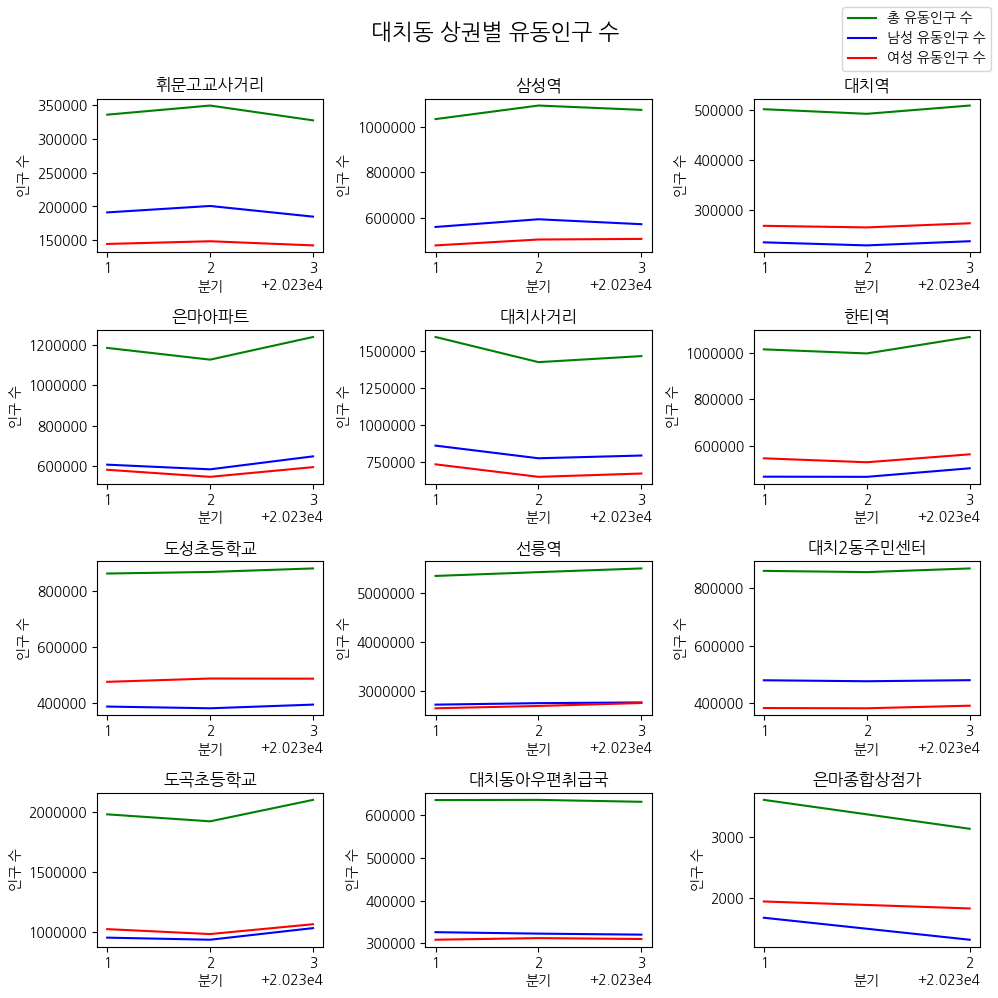

In [66]:
# 상권별 시각화

상권_list = 유df['상권_코드_명'].unique()

fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (10, 10))
fig.suptitle(동 + ' 상권별 유동인구 수\n', fontsize = 16)

for idx, 상권 in enumerate(상권_list):
    ax = axes[idx // 3, idx % 3]
    
    상권_df = 유df[유df['상권_코드_명'] == 상권]
    
    유df[유df['상권_코드_명'] == 상권].plot(x = '기준_년분기_코드', y = '총_유동인구_수', ax = ax, color = 'g', legend = False)
    유df[유df['상권_코드_명'] == 상권].plot(x = '기준_년분기_코드', y = '남성_유동인구_수', ax = ax, color = 'b', legend = False)
    유df[유df['상권_코드_명'] == 상권].plot(x = '기준_년분기_코드', y = '여성_유동인구_수', ax = ax, color = 'r', legend = False)
    ax.set_title(상권)
    ax.set_xlabel('분기')
    ax.set_ylabel('인구 수')
    ax.ticklabel_format(style = 'plain', axis = 'y')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer = True))
        
fig.legend(['총 유동인구 수', '남성 유동인구 수', '여성 유동인구 수'], loc = 'upper right')

plt.tight_layout()
plt.show()


In [54]:
# 상권별 매출총액 / 유동인구

매총df = 매df.groupby(['상권_코드_명', '기준_년분기_코드'])['당월_매출_금액'].sum().reset_index()
유총df = 유df.groupby(['상권_코드_명', '기준_년분기_코드', '상권_구분_코드_명'])['총_유동인구_수'].sum().reset_index()

매총유총df = pd.merge(매총df, 유총df, on=['상권_코드_명', '기준_년분기_코드'], how = 'inner')
매총유총df['비율'] = (매총유총df['당월_매출_금액'] / 매총유총df['총_유동인구_수']).round(2)

# 분기별 비율 순으로 정렬하여 상권 종류별 최상위 상권 반환
최상위df = 매총유총df.groupby(['기준_년분기_코드', '상권_구분_코드_명']).apply(lambda x: x.loc[x['비율'].idxmax(), ['기준_년분기_코드', '상권_코드_명']]).reset_index(drop=True)
최상위df


,기준_년분기_코드,상권_코드_명
0,20231,대치2동주민센터
1,20231,삼성역
2,20232,대치2동주민센터
3,20232,삼성역
4,20233,대치동아우편취급국
5,20233,삼성역


In [55]:
# 매df와 최상위df를 merge
매_merge = pd.merge(매df, 최상위df, on=['기준_년분기_코드', '상권_코드_명'], how='inner')
매_merge = 매_merge[['기준_년분기_코드', '상권_구분_코드_명', '상권_코드_명', '서비스_업종_코드_명', '당월_매출_금액']]

# 점df와 최상위df를 merge
점_merge = pd.merge(점df, 최상위df, on=['기준_년분기_코드', '상권_코드_명'], how='inner')
점_merge = 점_merge[['기준_년분기_코드', '상권_구분_코드_명', '상권_코드_명', '서비스_업종_코드_명', '점포_수']]

# 매_merge와 점_merge를 merge
최종_merge = pd.merge(매_merge, 점_merge, on=['기준_년분기_코드', '상권_구분_코드_명', '상권_코드_명', '서비스_업종_코드_명'], how='inner')

# '당월_매출_금액' / '점포_수' 값을 갖는 '평균매출' 칼럼 추가, 분기별, 상권종류별로 줄세우기
최종_merge['평균매출'] = (최종_merge['당월_매출_금액'] / 최종_merge['점포_수']).round(2)

최종_merge_sorted = 최종_merge.sort_values(by=['기준_년분기_코드', '상권_구분_코드_명', '평균매출'], ascending=[True, True, False])

# top3 업종만 남겨 가중치 할당
최종_merge_top3 = 최종_merge_sorted.groupby(['기준_년분기_코드', '상권_구분_코드_명']).head(3).reset_index(drop = True)

최종_merge_top3['가중치'] = 0

for 코드, 그룹 in 최종_merge_top3.groupby(['기준_년분기_코드', '상권_구분_코드_명']):
    평균매출_순위 = 그룹['평균매출'].rank(ascending=False, method='first')
    최종_merge_top3.loc[평균매출_순위.index, '가중치'] = 4 - 평균매출_순위

가중치df = 최종_merge_top3[['서비스_업종_코드_명', '가중치']]

# 업종별로 가중치 값을 합한 누적가중치 생성
누적가중치df = 가중치df.groupby('서비스_업종_코드_명')['가중치'].sum().reset_index()
누적가중치df.rename(columns={'가중치': '누적가중치'}, inplace=True)
누적가중치df


,서비스_업종_코드_명,누적가중치
0,분식전문점,3
1,일식음식점,2
2,중식음식점,9
3,커피-음료,5
4,한식음식점,9
5,호프-간이주점,6
